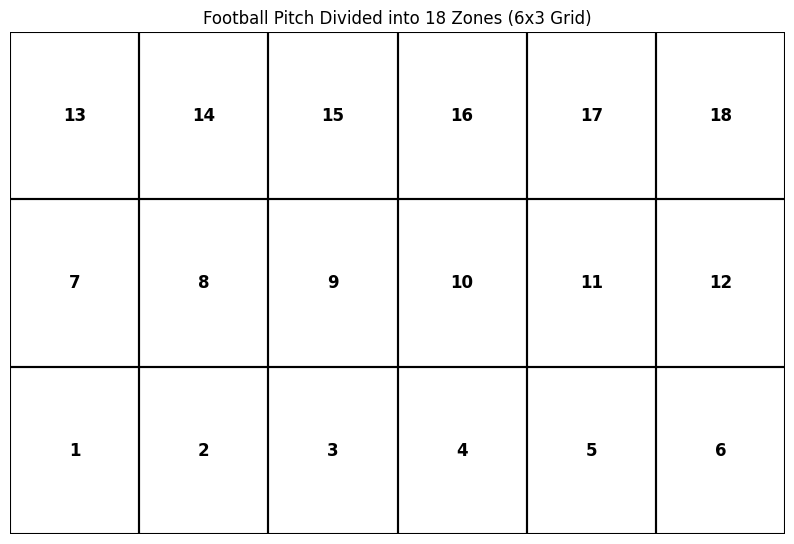

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set pitch dimensions
pitch_length = 105  # meters
pitch_width = 68    # meters

# Number of rows and columns for the zones
rows, cols = 6, 3  # Switching to 6 rows (horizontal) and 3 columns (vertical)
zone_height = pitch_width / cols
zone_width = pitch_length / rows

# Create the pitch figure
fig, ax = plt.subplots(figsize=(10, 7))
plt.xlim(0, pitch_length)
plt.ylim(0, pitch_width)
ax.set_aspect('equal')

# Draw the pitch zones
zone_num = 1
for col in range(cols):      # Iterate through columns
    for row in range(rows):  # Iterate through rows
        # Calculate bottom left corner of each rectangle
        x = row * zone_width
        y = col * zone_height
        # Draw a rectangle for each zone
        rect = patches.Rectangle((x, y), zone_width, zone_height, linewidth=1.5, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        # Label the zones in the center of each rectangle
        plt.text(x + zone_width / 2, y + zone_height / 2, str(zone_num),
                 ha='center', va='center', fontsize=12, fontweight='bold')
        zone_num += 1

# Hide the axes
ax.axis('off')

# Add title
plt.title("Football Pitch Divided into 18 Zones (6x3 Grid)")

plt.show()


/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


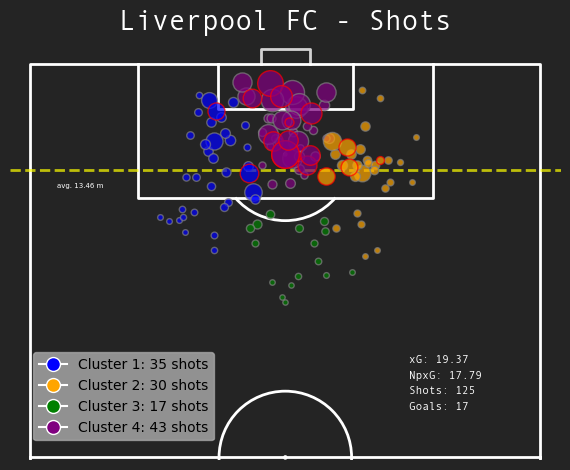

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from highlight_text import fig_text
from mplsoccer.pitch import VerticalPitch
from sklearn.cluster import KMeans
import numpy as np

text_color = 'w'

# Load data
df = pd.read_excel(r'/Users/marclambertes/Python/LIVXG.xlsx')

# Filter data for Liverpool FC
df = df.loc[(df['TeamId'] == 'Liverpool FC')].reset_index()

# Calculate summary statistics
total_xG = df['xG'].sum()
total_shots = df.shape[0]
total_goals = df['isGoal'].sum()

# Calculate total xG from penalties and non-penalty xG
total_xG_from_penalties = df[df['Type_of_play'] == 'Penalty']['xG'].sum()
total_xG_minus_penalties = total_xG - total_xG_from_penalties

# Perform clustering on shot positions
shot_positions = df[['y', 'x']]
kmeans = KMeans(n_clusters=4, random_state=0).fit(shot_positions)
df['cluster'] = kmeans.labels_

# Define cluster colors
cluster_colors = ['blue', 'orange', 'green', 'purple']

# Count shots in each cluster
cluster_counts = df['cluster'].value_counts().sort_index()

# Build the pitch
pitch = VerticalPitch(pitch_type='opta', pad_bottom=0.5, pad_top=5, pitch_color='#242424', line_color='white',
                      half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw()
fig.set_facecolor('#242424')

# Plot the shots with colors based on clusters
for x in range(len(df['x'])):
    shot_color = 'red' if df['isGoal'][x] else 'grey'
    cluster_color = cluster_colors[df['cluster'][x]]
    
    plt.scatter(df['y'][x], df['x'][x], color=cluster_color, edgecolor=shot_color,
                s=df['xG'][x]*500, alpha=0.7, zorder=3 if df['isGoal'][x] else 2)

# Calculate and plot average distance line
avg_x = df['y'].mean()
avg_y = df['x'].mean()
plt.axhline(y=avg_y, color='yellow', linestyle='dashed', linewidth=2, alpha=0.7, zorder=1)

# Add average distance text
text_y_offset = -2
text_x_offset = 45
plt.text(avg_x + text_x_offset, avg_y + text_y_offset, f'avg. {average_meters_from_goal:.2f} m',
         fontsize=5, color='white', ha='left', va='center')

# Legend setup
legend_elements = []
for i in range(len(cluster_counts)):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}: {cluster_counts[i]} shots',
                                      markerfacecolor=cluster_colors[i], markersize=10))

plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0.03, 0.03), prop={'size': 10}, framealpha=0.5)

# Display summary statistics
table_text = f'xG: {total_xG:.2f}\nNpxG: {total_xG_minus_penalties:.2f}\nShots: {total_shots}\nGoals: {total_goals}'
fig_text(0.75, 0.25, table_text, fontsize=8, color='white', ha='center', fontfamily='Andale Mono')

# Plot title and save
plt.title('Liverpool FC - Shots', fontfamily='Andale Mono', color='white', size=20)
plt.savefig('shotmap_clustered.png', dpi=750, bbox_inches='tight', facecolor='#242424')
plt.show()


In [27]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import random

# Load and filter data for Liverpool FC
df = pd.read_excel(r'/Users/marclambertes/Python/LIVXG.xlsx')
df = df.loc[df['TeamId'] == 'Liverpool FC'].reset_index()

# Extract shot locations and xG values
shot_positions = df[['y', 'x', 'xG']]

# Cluster the historical shot data
kmeans = KMeans(n_clusters=4, random_state=0).fit(shot_positions[['y', 'x']])
df['cluster'] = kmeans.labels_

# Find centroid (average position) for each cluster
cluster_centroids = kmeans.cluster_centers_

# Calculate probabilities for each cluster based on shot frequency
cluster_counts = df['cluster'].value_counts().sort_index()
total_shots = cluster_counts.sum()
cluster_probabilities = cluster_counts / total_shots

# Calculate average xG for each cluster
average_xG_per_cluster = df.groupby('cluster')['xG'].mean().values

# Predict shot locations for the next game based on historical cluster data
num_predicted_shots = 14  # Fixed number of predicted shots for the next game
predicted_shots = []

for _ in range(num_predicted_shots):
    # Choose a cluster based on the probability distribution
    cluster_choice = np.random.choice(range(len(cluster_probabilities)), p=cluster_probabilities)
    
    # Add some random variation around the centroid to simulate a real shot location
    y_pred = cluster_centroids[cluster_choice][0] + random.gauss(0, 3)  # Adjust 3 to control spread
    x_pred = cluster_centroids[cluster_choice][1] + random.gauss(0, 3)
    
    # Use the average xG for the selected cluster
    xg_pred = average_xG_per_cluster[cluster_choice]
    
    predicted_shots.append((y_pred, x_pred, xg_pred))

# Convert predicted shot locations to a DataFrame for easier handling or visualization
predicted_shots_df = pd.DataFrame(predicted_shots, columns=['y', 'x', 'xG'])

# Display predicted shot locations
print(predicted_shots_df)


            y          x        xG
0   30.006686  87.839828  0.104499
1   37.573405  86.527619  0.104499
2   50.685721  86.719848  0.275936
3   40.296251  88.894519  0.104499
4   66.230999  90.224156  0.101274
5   32.847184  85.948521  0.104499
6   42.731717  89.849842  0.275936
7   34.828003  83.988844  0.104499
8   61.170426  85.729167  0.101274
9   30.361979  86.352264  0.104499
10  29.233081  80.120683  0.104499
11  39.665278  84.192056  0.104499
12  53.770369  89.895496  0.275936
13  51.258202  93.972960  0.275936


/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


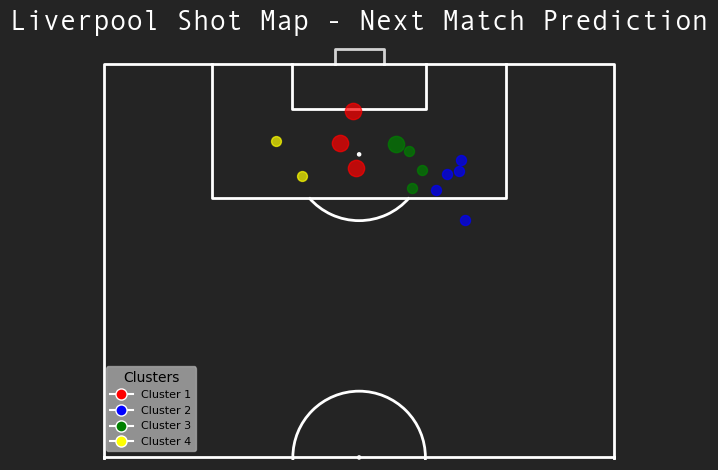

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
from sklearn.cluster import KMeans

# Perform KMeans clustering on the predicted shots
kmeans = KMeans(n_clusters=4, random_state=0).fit(predicted_shots_df[['y', 'x']])
predicted_shots_df['cluster'] = kmeans.labels_

# Build the pitch
pitch = VerticalPitch(pitch_type='opta', pad_bottom=0.5, pad_top=5, 
                      pitch_color='#242424', line_color='white', 
                      half=True, goal_type='box', goal_alpha=0.8)

fig, ax = pitch.draw()
fig.set_facecolor('#242424')

# Define colors for each cluster
colors = ['red', 'blue', 'green', 'yellow']

# Plot the predicted shots with cluster colors
for index, row in predicted_shots_df.iterrows():
    # Cast cluster to integer for indexing
    cluster_index = int(row['cluster'])
    plt.scatter(row['y'], row['x'], color=colors[cluster_index], 
                s=row['xG'] * 500, alpha=0.7, zorder=2)

# Create a legend
legend_labels = [f'Cluster {i+1}' for i in range(4)]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) for color in colors]
plt.legend(handles, legend_labels, title='Clusters', loc='lower left', bbox_to_anchor=(0.03, 0.007), prop={'size': 8}, framealpha=0.5)

# Display the plot title
plt.title('Liverpool Shot Map - Next Match Prediction', fontfamily='Andale Mono', color='white', size=20)

# Save and show the figure
plt.savefig('shotmap_data_with_clusters.png', dpi=750, bbox_inches='tight', facecolor='#242424')
plt.show()
